In [6]:
%reload_ext autoreload
%autoreload 2

In [183]:
import utils as u
import importlib
importlib.reload(u)
import pandas as pd
import io
import requests
from IPython.display import display, Markdown, Latex
from sbpy.data import Ephem

from astroquery.imcce import Skybot
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as ut
import matplotlib.pyplot as plt

## Study the skybot associations

In [18]:
skybot_res = pd.read_parquet("skybot_result_15_2_2.parquet")
r_orb = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'orbParams', # Mandatory, `orbParams` or `lightcurves`
  }
)
candid_reconstr_orbit = pd.read_json(io.BytesIO(r_orb.content))

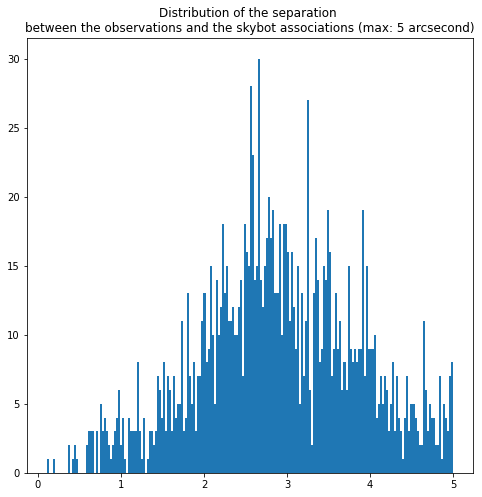


|                 |  |
|-----------------|--|
|Total observation|2025|
|Alerts with SkyBot counterparts|1503 (74.22222222222223 %)|
|Total orbit|327|
|Pure orbit candidate|145 (44.342507645259936 %)|
|Not Pure orbit|123 (37.61467889908257 %)|
|Unknown orbit|59 (18.04281345565749 %)|


In [12]:
# 15_2_2 exp
skybot_markdown_15_2_2, pure_skybot, not_pure_skybot, unknown_skybot = u.skybot_analysis(skybot_res)
Markdown(skybot_markdown_15_2_2)

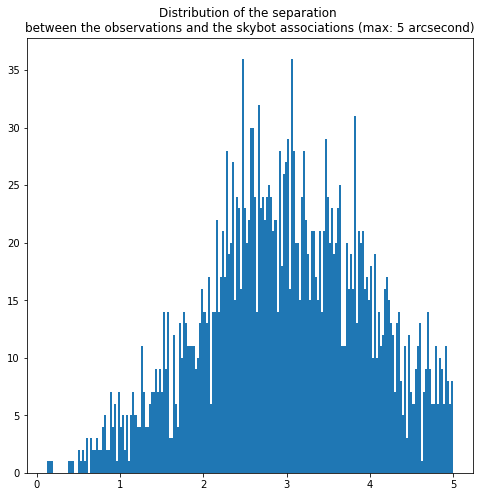


|                 |  |
|-----------------|--|
|Total observation|3686|
|Alerts with SkyBot counterparts|2509 (68.06836679327184 %)|
|Total orbit|597|
|Pure orbit candidate|208 (34.84087102177554 %)|
|Not Pure orbit|253 (42.3785594639866 %)|
|Unknown orbit|136 (22.780569514237854 %)|


In [13]:
# 15_2_8 exp

skybot_markdown_15_2_8, _, _, _ = u.skybot_analysis(pd.read_parquet("skybot_result.parquet"))
Markdown(skybot_markdown_15_2_8)

In [191]:
orb_not_pure = candid_reconstr_orbit[candid_reconstr_orbit["d:ssoCandId"].isin(not_pure_skybot["d:ssoCandId"])]
without_error = orb_not_pure[orb_not_pure["d:rms_a"] == -1.0]
with_error = orb_not_pure[orb_not_pure["d:rms_a"] != -1.0]

Markdown("""
Not pure orbit stats
* with error: {} ({:.2f} %)
* without error: {} ({:.2f} %)
""".format(
    len(with_error), len(with_error) / len(orb_not_pure) * 100,
    len(without_error), len(without_error) / len(orb_not_pure) * 100
))


Not pure orbit stats
* with error: 43 (34.96 %)
* without error: 80 (65.04 %)


## Study the wrong Fink-FAT association

In [14]:
not_pure_traj = skybot_res[skybot_res["d:ssoCandId"].isin(not_pure_skybot["d:ssoCandId"])].sort_values(["d:ssoCandId", "d:jd"])
not_pure_traj.columns = [cols[2:] if cols[:2] == "d:" else cols for cols in not_pure_traj.columns]

In [212]:
res_sep_dict = {
    "ssoCandId": [],
    "pred_ra": [],
    "pred_dec": [],
    "objectId": [],
    "candid": [],
    "Ast_Name": [],
    "sep_ephem_skybot": []
}

for ssoCandId in not_pure_traj["ssoCandId"].unique():
    # print("Orbit candidate: {}".format(ssoCandId))

    tmp_sso = not_pure_traj[not_pure_traj["ssoCandId"] == ssoCandId].reset_index(drop=True)
    tmp_orb = candid_reconstr_orbit[candid_reconstr_orbit["d:ssoCandId"] == ssoCandId]
    list_pred = []
    list_sep = []

    for ast_name in tmp_sso["Ast_Name"].unique():
        if ast_name == "null":
            continue
        # print("\tSkybot Assoc: {}".format(ast_name))

        sep_skybot_assoc, pred, obs = u.compute_sep_from_ztf(not_pure_traj, ssoCandId, ast_name)
        
        for i, sep in enumerate(sep_skybot_assoc):
            tmp_obs = tmp_sso.iloc[i]
            res_sep_dict["ssoCandId"].append(ssoCandId)
            res_sep_dict["pred_ra"].append(pred.ra[i].degree)
            res_sep_dict["pred_dec"].append(pred.dec[i].degree)
            res_sep_dict["objectId"].append(tmp_obs["objectId"])
            res_sep_dict["candid"].append(tmp_obs["candid"])
            res_sep_dict["Ast_Name"].append(ast_name)
            res_sep_dict["sep_ephem_skybot"].append(sep.arcsecond)
        

        list_pred.append((pred, ast_name))
        list_sep.append(sep_skybot_assoc)
        # print("\t\tSeparation with ZTF alerts: ", sep_skybot_assoc)

    
    u.plot_ff_error(ssoCandId, obs, *list_pred)
    # print("-----")
    # print()

In [213]:
res_ephem = pd.DataFrame(res_sep_dict)
skybot_and_ephem = res_ephem.merge(not_pure_traj, on=["ssoCandId", "objectId", "candid"], how="inner")
skybot_ephem_orb = skybot_and_ephem.merge(
    candid_reconstr_orbit[["d:ssoCandId", "d:a", "d:rms_a", "d:e", "d:rms_e", "d:i", "d:rms_i"]], 
    left_on="ssoCandId", right_on="d:ssoCandId")

In [214]:
def print_orb_err(ssoCandId):
    tmp_orb = candid_reconstr_orbit[candid_reconstr_orbit["d:ssoCandId"] == ssoCandId]
    print("{}: a: {:.4f} ± {:.4f}, e: {:.4f} ± {:.4f}, i: {:.4f} ± {:.4f}".format(
            ssoCandId, tmp_orb["d:a"].values[0], tmp_orb["d:rms_a"].values[0],
            tmp_orb["d:e"].values[0], tmp_orb["d:rms_e"].values[0],
            tmp_orb["d:i"].values[0], tmp_orb["d:rms_i"].values[0]
        ))

### Study of a good trajectory: FF2023aaaaaab

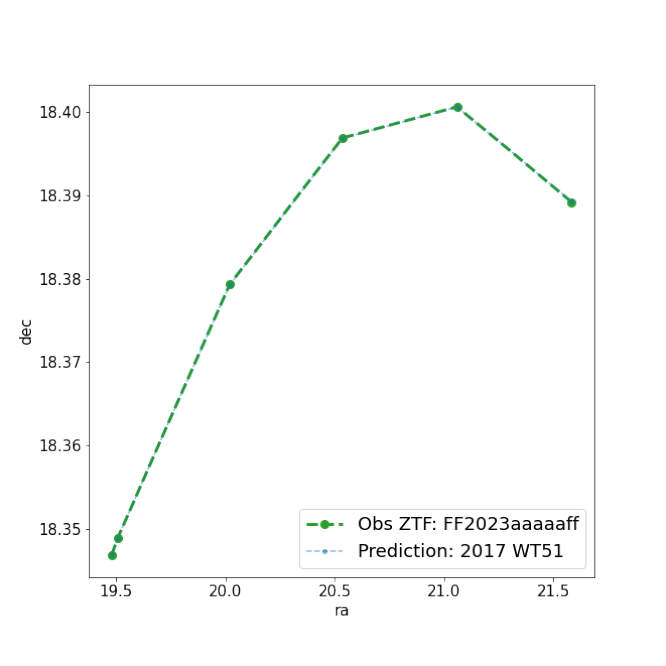


---Skybot checking---
obs: ZTF20acikigg, time: 2020-10-12 07:54:23.003
        Name  centerdist
0  2017 WT51       3.225
obs: ZTF20acjboyz, time: 2020-10-14 07:54:09.999
        Name  centerdist
0  2017 WT51       3.009
obs: ZTF20acjwqsj, time: 2020-10-16 07:44:20.000
        Name  centerdist
0  2017 WT51       2.848
obs: ZTF20ackpfxm, time: 2020-10-18 07:07:26.000
        Name  centerdist
0  2017 WT51       3.098
obs: ZTF20acljqpw, time: 2020-10-20 06:53:30.002
        Name  centerdist
0  2017 WT51       3.359
obs: ZTF20aclkttp, time: 2020-10-20 09:18:05.003
        Name  centerdist
0  2017 WT51       6.067

--Orbit parameters--

FF2023aaaaaff: a: 2.1362 ± 0.0310, e: 0.2100 ± 0.0037, i: 5.9348 ± 0.1689


In [215]:
ssoCandGood = "FF2023aaaaaff"

good_traj_data = skybot_ephem_orb[skybot_ephem_orb["ssoCandId"] == ssoCandGood]

image = plt.imread("skybot_deviation_plot/{}.png".format(ssoCandGood))
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(image)
ax.axis('off')
plt.show()

# skybot verification

print()
print("---Skybot checking---")
for objectId, ra, dec, jd in zip(
    good_traj_data["objectId"].values, good_traj_data["ra"].values, good_traj_data["dec"].values, good_traj_data["jd"].values):

    print("obs: {}, time: {}".format(objectId, Time(jd, format="jd").iso))
    try:
        coord = SkyCoord(ra, dec, unit=ut.degree)
        epoch = Time(jd, format="jd")
        results = Skybot.cone_search(coord, 10*ut.arcsec, epoch).to_pandas()[["Name", "centerdist"]]
        print(results)
    except RuntimeError:
        print("no skybot counterparts")

print()
print("--Orbit parameters--")
print()
print_orb_err(ssoCandGood)

- Conclusion
    * All the alerts are associateds with the same asteroids by the SkyBot with a limit at 10 arcsecond.
    * Orbit least square optimisation success, rms error available

### Study of a good trajectory: FF2023aaaaakz

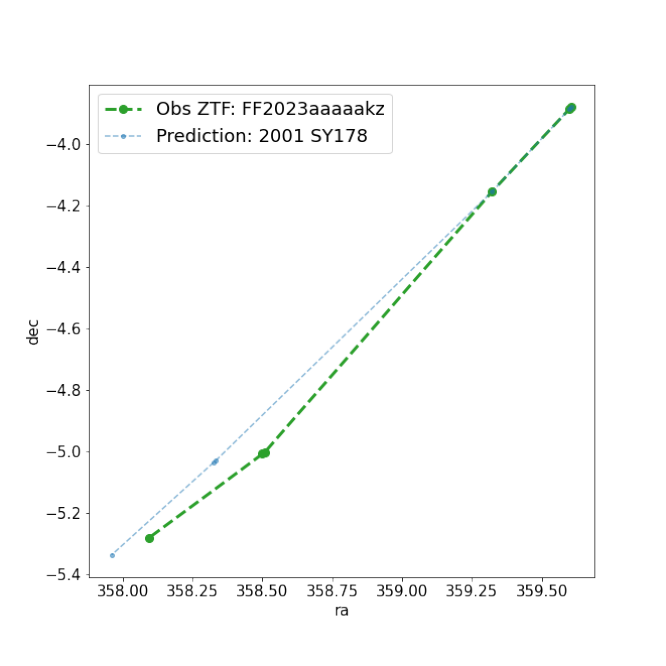


---Skybot checking---
obs: ZTF21abvuprj, time: 2021-08-27 08:04:39.000
         Name  centerdist
0  2001 SY178       4.899
obs: ZTF21abvwbic, time: 2021-08-27 09:29:35.002
         Name  centerdist
0  2001 SY178       4.203
obs: ZTF21abwkfms, time: 2021-08-29 08:36:34.004
         Name  centerdist
0  2001 SY178       4.495
obs: ZTF21abxtzde, time: 2021-09-04 08:57:54.996
        Name  centerdist
0  2004 NE13       5.192
obs: ZTF21abxvwdv, time: 2021-09-04 09:55:52.000
        Name  centerdist
0  2004 NE13       5.277
obs: ZTF21abyptly, time: 2021-09-06 09:17:53.002
        Name  centerdist
0  2004 NE13       5.292

--Orbit parameters--

FF2023aaaaakz: a: 3.0601 ± -1.0000, e: 0.2297 ± -1.0000, i: 18.6915 ± -1.0000


In [216]:
ssoCandGood = "FF2023aaaaakz"

good_traj_data = skybot_ephem_orb[skybot_ephem_orb["ssoCandId"] == ssoCandGood]

image = plt.imread("skybot_deviation_plot/{}.png".format(ssoCandGood))
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(image)
ax.axis('off')
plt.show()

# skybot verification

print()
print("---Skybot checking---")
sep_dist = dict()
for objectId, ra, dec, jd in zip(
    good_traj_data["objectId"].values, good_traj_data["ra"].values, good_traj_data["dec"].values, good_traj_data["jd"].values):

    print("obs: {}, time: {}".format(objectId, Time(jd, format="jd").iso))
    try:
        coord = SkyCoord(ra, dec, unit=ut.degree)
        epoch = Time(jd, format="jd")
        results = Skybot.cone_search(coord, 10*ut.arcsec, epoch).to_pandas()[["Name", "centerdist"]]
        print(results)
        v = sep_dist.get("Name", )
    except RuntimeError:
        print("no skybot counterparts")

print()
print("--Orbit parameters--")
print()
print_orb_err(ssoCandGood)

- Conclusion
    * One asteroids associations return by the SkyBot with a limit at 10 arcsecond.
    * One ZTF observations with no SkyBot associations within 10 arcsecond.
    * Trajectory not very credible
    * Orbit least square optimisation have failed, no rms error

### Study of a good trajectory: FF2023aaaaaba

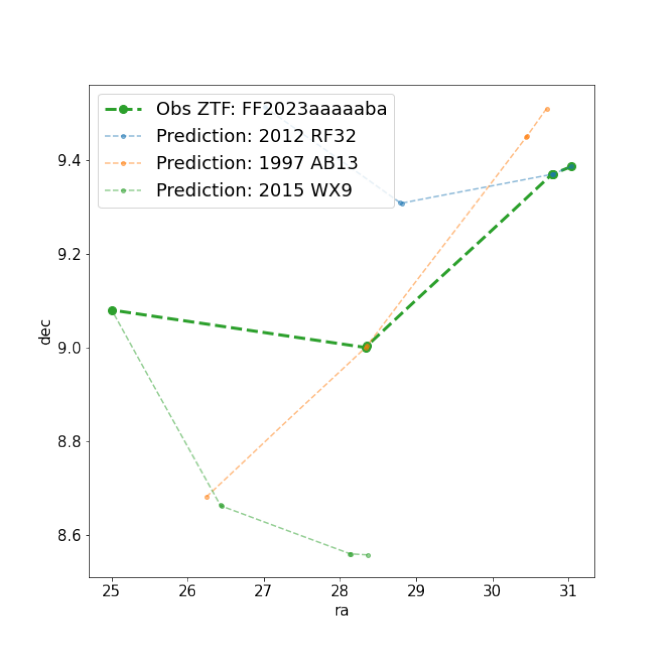


---Skybot checking---
obs: ZTF19acnjchw, time: 2019-11-03 06:56:23.001
        Name  centerdist
0  2012 RF32       3.894
obs: ZTF19acoagrd, time: 2019-11-04 07:02:39.998
        Name  centerdist
0  2012 RF32       3.952
obs: ZTF19acocjmw, time: 2019-11-04 08:08:15.000
        Name  centerdist
0  2012 RF32       3.965
obs: ZTF19acryebn, time: 2019-11-13 05:11:06.996
        Name  centerdist
0  1997 AB13       3.453
obs: ZTF19acrzcav, time: 2019-11-13 07:36:05.999
        Name  centerdist
0  1997 AB13       2.954
obs: ZTF19acvhhrc, time: 2019-11-25 04:56:11.996
       Name  centerdist
0  2015 WX9       3.502

--Orbit parameters--

FF2023aaaaaba: a: 2.9772 ± -1.0000, e: 0.6597 ± -1.0000, i: 1.9305 ± -1.0000


In [217]:
ssoCandGood = "FF2023aaaaaba"

good_traj_data = skybot_ephem_orb[skybot_ephem_orb["ssoCandId"] == ssoCandGood].drop_duplicates("candid")

image = plt.imread("skybot_deviation_plot/{}.png".format(ssoCandGood))
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(image)
ax.axis('off')
plt.show()

# skybot verification

print()
print("---Skybot checking---")
for objectId, ra, dec, jd in zip(
    good_traj_data["objectId"].values, good_traj_data["ra"].values, good_traj_data["dec"].values, good_traj_data["jd"].values):

    print("obs: {}, time: {}".format(objectId, Time(jd, format="jd").iso))
    try:
        coord = SkyCoord(ra, dec, unit=ut.degree)
        epoch = Time(jd, format="jd")
        results = Skybot.cone_search(coord, 10*ut.arcsec, epoch).to_pandas()[["Name", "centerdist"]]
        print(results)
    except RuntimeError:
        print("no skybot counterparts")

print()
print("--Orbit parameters--")
print()
print_orb_err(ssoCandGood)

- Conclusion
    * Multiple asteroid associations return by the SkyBot with a limit at 10 arcsecond.
    * Trajectory not credible
    * Orbit least square optimisation have failed, no rms error

### Study of a good trajectory: FF2023aaaaaaq

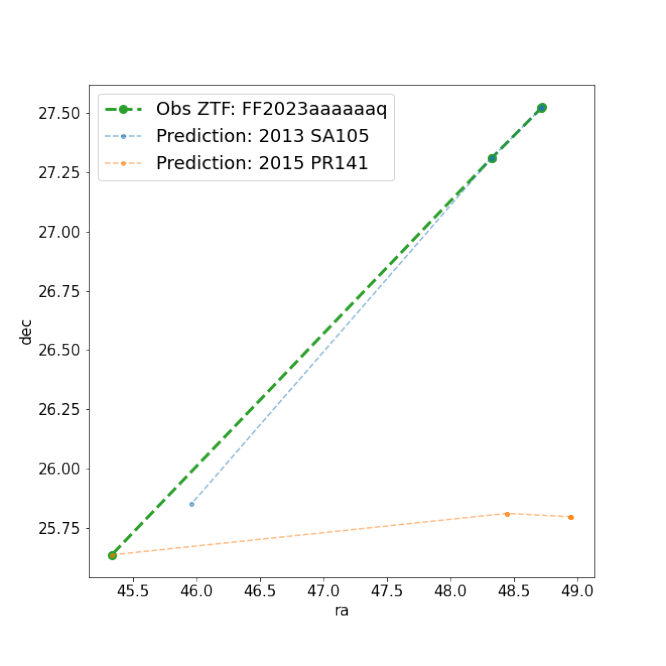


---Skybot checking---
obs: ZTF19acoaqsb, time: 2019-11-04 07:08:02.003
         Name  centerdist
0  2013 SA105       2.333
obs: ZTF19acoccjn, time: 2019-11-04 08:04:55.001
         Name  centerdist
0  2013 SA105       0.747
obs: ZTF19acoccjn, time: 2019-11-04 08:06:55.002
         Name  centerdist
0  2013 SA105       0.828
obs: ZTF19acpfvca, time: 2019-11-06 08:48:11.002
         Name  centerdist
0  2013 SA105       0.859
obs: ZTF19acpfvca, time: 2019-11-06 08:49:30.999
         Name  centerdist
0  2013 SA105       0.811
obs: ZTF19actkcop, time: 2019-11-18 08:13:36.002
         Name  centerdist
0  2015 PR141       2.204

--Orbit parameters--

FF2023aaaaaaq: a: 32.6075 ± -1.0000, e: 0.9657 ± -1.0000, i: 10.4950 ± -1.0000


In [218]:
ssoCandGood = "FF2023aaaaaaq"

good_traj_data = skybot_ephem_orb[skybot_ephem_orb["ssoCandId"] == ssoCandGood].drop_duplicates("candid")

image = plt.imread("skybot_deviation_plot/{}.png".format(ssoCandGood))
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(image)
ax.axis('off')
plt.show()

# skybot verification

print()
print("---Skybot checking---")
for objectId, ra, dec, jd in zip(
    good_traj_data["objectId"].values, good_traj_data["ra"].values, good_traj_data["dec"].values, good_traj_data["jd"].values):

    print("obs: {}, time: {}".format(objectId, Time(jd, format="jd").iso))
    try:
        coord = SkyCoord(ra, dec, unit=ut.degree)
        epoch = Time(jd, format="jd")
        results = Skybot.cone_search(coord, 10*ut.arcsec, epoch).to_pandas()[["Name", "centerdist"]]
        print(results)
    except RuntimeError:
        print("no skybot counterparts")

print()
print("--Orbit parameters--")
print()
print_orb_err(ssoCandGood)